## sp500_Index


## Libraries used

In [1]:
!pip install pandas
!pip install prophet
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split, GridSearchCV

C:\Users\dell\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Loading dataset

In [11]:
data = pd.read_csv('sp500_index.csv',parse_dates=True)
data

,Date,S&P500
0,2014-05-12,1896.65
1,2014-05-13,1897.45
2,2014-05-14,1888.53
3,2014-05-15,1870.85
4,2014-05-16,1877.86
...,...,...
2513,2024-05-06,5180.74
2514,2024-05-07,5187.70
2515,2024-05-08,5187.67
2516,2024-05-09,5214.08


### Cleaning Dataset

In [12]:
print("Mising values in dataset")
print(data.isnull().sum())

Mising values in dataset
Date      0
S&P500    0
dtype: int64


# Normalization/Standardization

In [13]:
scaler = StandardScaler()
data[['S&P500']]= scaler.fit_transform(data[['S&P500']])
print(data)

            Date    S&P500
0     2014-05-12 -1.289492
1     2014-05-13 -1.288649
2     2014-05-14 -1.298049
3     2014-05-15 -1.316681
4     2014-05-16 -1.309293
...          ...       ...
2513  2024-05-06  2.171431
2514  2024-05-07  2.178766
2515  2024-05-08  2.178734
2516  2024-05-09  2.206566
2517  2024-05-10  2.215629

[2518 rows x 2 columns]


# Stationarization

In [14]:
data['S&P500_log'] = np.log(data['S&P500']+1)


C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Differencing

In [16]:
data['S&P500_diff'] = np.log(data['S&P500'].diff().dropna())


C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
print(data[['S&P500']])

        S&P500
0    -1.289492
1    -1.288649
2    -1.298049
3    -1.316681
4    -1.309293
...        ...
2513  2.171431
2514  2.178766
2515  2.178734
2516  2.206566
2517  2.215629

[2518 rows x 1 columns]


# ARIMA MODEL

## Visualize the Time series

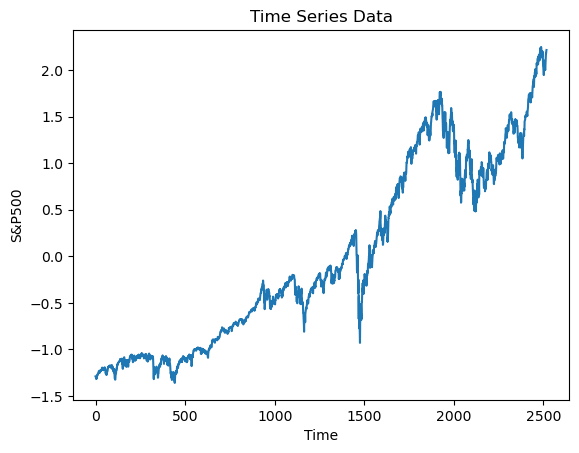

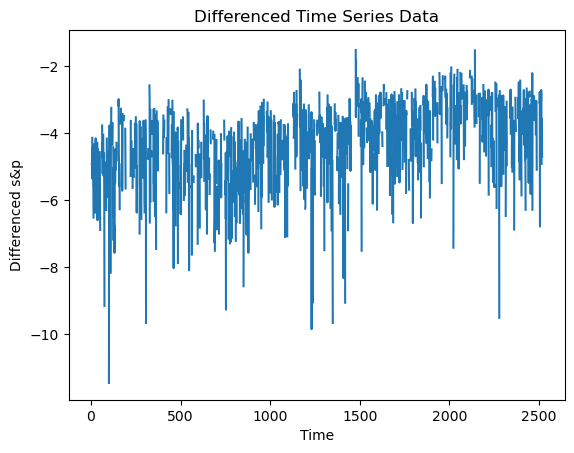

In [18]:
plt.plot(data['S&P500'])
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('S&P500')
plt.show()
# Visualize the differenced time series data
plt.plot(data['S&P500_diff'])
plt.title('Differenced Time Series Data')
plt.xlabel('Time')
plt.ylabel('Differenced s&p')
plt.show()

# Stationarity check


In [19]:
result = adfuller(data['S&P500'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# If p-value < 0.05, data is stationary, otherwise, perform differencing


ADF Statistic: 0.0420582935048994
p-value: 0.9618751193235549


In [20]:
data['S&P500_diff'] = data['S&P500'].diff()

# Drop the first row with NaN resulting from differencing
data.dropna(inplace=True)

result = adfuller(data['S&P500_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -13.359169306770093
p-value: 5.471528373439669e-25


# Plot ACF and PACF


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


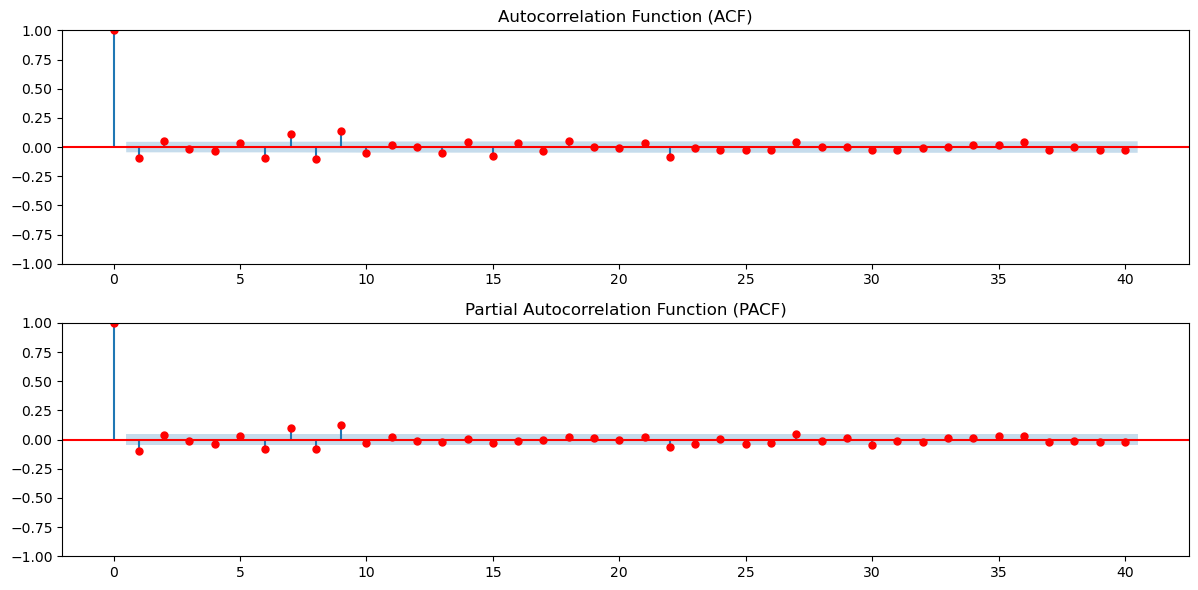

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(data['S&P500_diff'],color='red', ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.subplot(212)
plot_pacf(data['S&P500_diff'],color='red', ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


# Model Selection 


In [22]:
# Based on ACF and PACF plots and statistical tests
p = 5  # Number of significant spikes in PACF plot
d = 0  # No differencing needed as the data is already stationary
q = 36  # Number of significant spikes in ACF plot

# Step 6: Model Training
model = ARIMA(data['S&P500'], order=(p, d, q))
model_fit = model.fit()

# Step 7: Model Evaluation
print(model_fit.summary())


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 S&P500   No. Observations:                 1909
Model:                ARIMA(5, 0, 36)   Log Likelihood                3415.007
Date:                Tue, 14 May 2024   AIC                          -6744.014
Time:                        00:01:23   BIC                          -6505.178
Sample:                             0   HQIC                         -6656.111
                               - 1909                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3668      6.417      0.057      0.954     -12.211      12.945
ar.L1          0.7927      0.804      0.986      0.324      -0.784       2.369
ar.L2          0.4058      1.176      0.345      0.7

## Forecasting

In [23]:
forecast_steps = 10  # Forecast 10 future time periods
forecast_values = model_fit.forecast(steps=forecast_steps)

# Create a DataFrame to store forecasted values
forecast_df = pd.DataFrame({'Forecasted Values': forecast_values})

# Display forecasted values in tabular format
print("Forecasted Values:")
forecast_df


Forecasted Values:


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Forecasted Values
1909,2.198228
1910,2.199197
1911,2.204196
1912,2.216449
1913,2.220583
1914,2.226716
1915,2.229108
1916,2.229519
1917,2.223444
1918,2.215194


# ANN

### Preparing Dataset

In [26]:
#ANN
data = data.dropna(subset=['S&P500_log'])

In [28]:
x= data['S&P500_log'].values.reshape(-1,1)
y = data['S&P500_log'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


## Designing ANN

In [30]:
# Function to create a model
def create_model(n_layers, n_neurons):
    model = Sequential()
    model.add(Dense(units=n_neurons, activation='relu', input_dim=1))  # Input layer
    for _ in range(n_layers - 1):
        model.add(Dense(units=n_neurons, activation='relu'))  # Adding hidden layers
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Training the model

In [31]:
layer_options = [1, 2, 3]  # Different number of layers
neuron_options = [20, 50, 100]  # Different number of neurons

results = {}
for layers in layer_options:
    for neurons in neuron_options:
        model = create_model(layers, neurons)
        model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=0)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        results[(layers, neurons)] = mse
        print(f'Layers: {layers}, Neurons: {neurons}, MSE: {mse}')


12/12 [==============================] - 0s 3ms/step
Layers: 1, Neurons: 20, MSE: 6.839169931713869e-09
12/12 [==============================] - 0s 2ms/step
Layers: 1, Neurons: 50, MSE: 4.1789799455700435e-07
12/12 [==============================] - 0s 2ms/step
Layers: 1, Neurons: 100, MSE: 9.030511566659632e-08
12/12 [==============================] - 0s 2ms/step
Layers: 2, Neurons: 20, MSE: 5.001494406369848e-07
12/12 [==============================] - 0s 2ms/step
Layers: 2, Neurons: 50, MSE: 4.470839597758493e-06
12/12 [==============================] - 0s 2ms/step
Layers: 2, Neurons: 100, MSE: 0.00012632492109113723
12/12 [==============================] - 0s 2ms/step
Layers: 3, Neurons: 20, MSE: 7.770833159004265e-06
12/12 [==============================] - 0s 2ms/step
Layers: 3, Neurons: 50, MSE: 3.6498632979340704e-07
12/12 [==============================] - 0s 2ms/step
Layers: 3, Neurons: 100, MSE: 1.320142111536564e-06


## Evaluating the model

In [32]:
best_architecture = min(results, key=results.get)
best_mse = results[best_architecture]
print(f'Best Architecture -> Layers: {best_architecture[0]}, Neurons: {best_architecture[1]}, MSE: {best_mse}')

Best Architecture -> Layers: 1, Neurons: 20, MSE: 6.839169931713869e-09


## Visualize the data

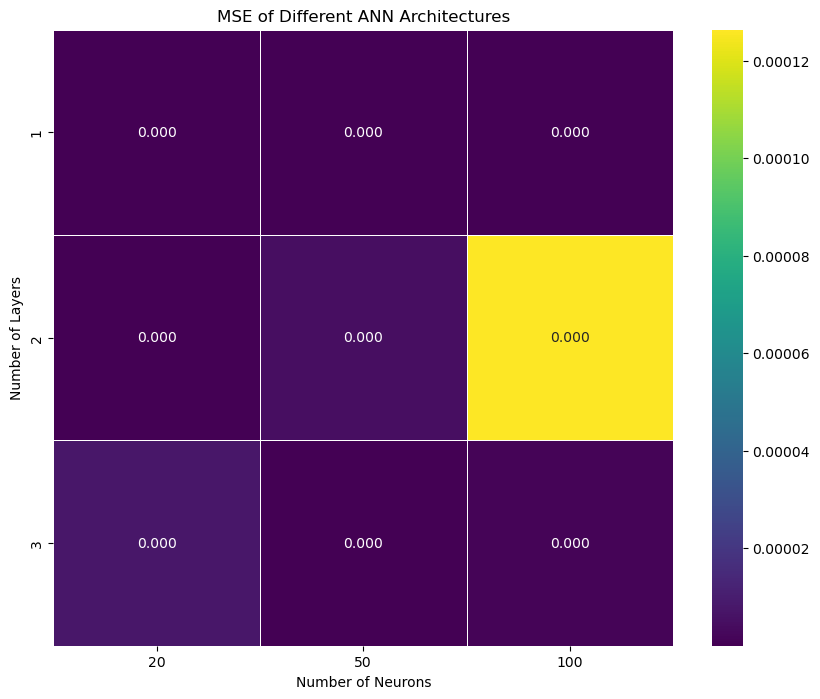

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'results' is a dictionary with keys as (layers, neurons) and values as MSE
data = {'Layers': [], 'Neurons': [], 'MSE': []}
for (layers, neurons), mse in results.items():
    data['Layers'].append(layers)
    data['Neurons'].append(neurons)
    data['MSE'].append(mse)

# Create a DataFrame
df = pd.DataFrame(data)

# Corrected pivot call: specify index, columns, and values explicitly
pivot_table = df.pivot(index='Layers', columns='Neurons', values='MSE')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
ax = plt.subplot()

# Draw the heatmap
sns.heatmap(pivot_table, annot=True, fmt=".3f", linewidths=.5, ax=ax, cmap="viridis")

# Title and labels
ax.set_title('MSE of Different ANN Architectures')
ax.set_xlabel('Number of Neurons')
ax.set_ylabel('Number of Layers')

# Show the plot
plt.show()


# SARIMA (Seasonal ARIMA):

In [36]:
#SARIMA
data = pd.read_csv('sp500_index.csv', parse_dates=True)

ts = data['S&P500']

## Checking if data is stationary


In [37]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value:.3f}')

adf_test(ts)


ADF Statistic: 0.042058293504710284
p-value: 0.9618751193235404
Critical Values:
    1%: -3.433
    5%: -2.863
    10%: -2.567


## Seasonal Decomposition


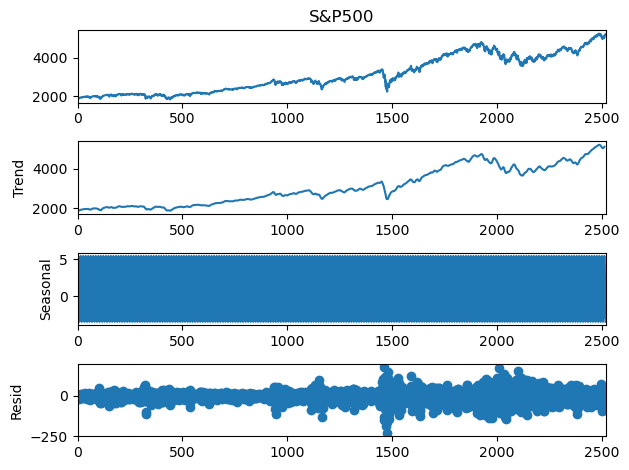

In [38]:
result = seasonal_decompose(ts, model='additive', period=12)  # change period based on your data's seasonality
result.plot()
plt.show()


# Identifying SARIMA Parameters

C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


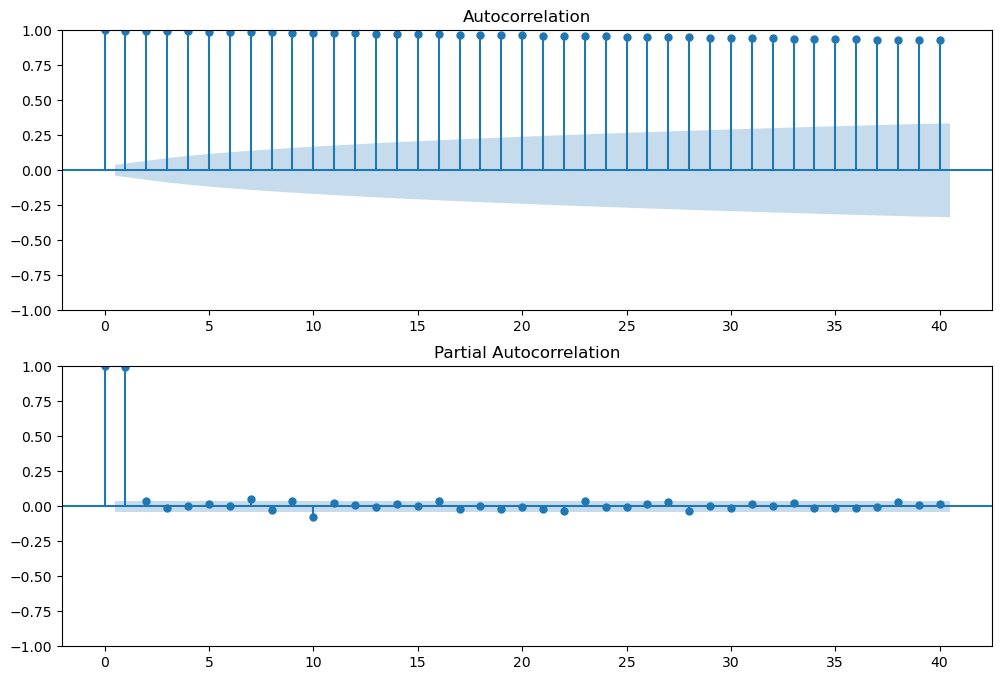

In [39]:
# Non-seasonal
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts, ax=ax[0], lags=40)  
plot_pacf(ts, ax=ax[1], lags=40)  
plt.show()



## Fitting SARIMA MODEL

In [40]:
model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                             S&P500   No. Observations:                 2518
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -12524.341
Date:                            Tue, 14 May 2024   AIC                          25058.682
Time:                                    00:14:04   BIC                          25087.813
Sample:                                         0   HQIC                         25069.257
                                           - 2518                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3555      0.086     -4.154      0.000      -0.523      -0.188
ma.L1          0.2650      0.089   

## Model Diagnostics and Validation

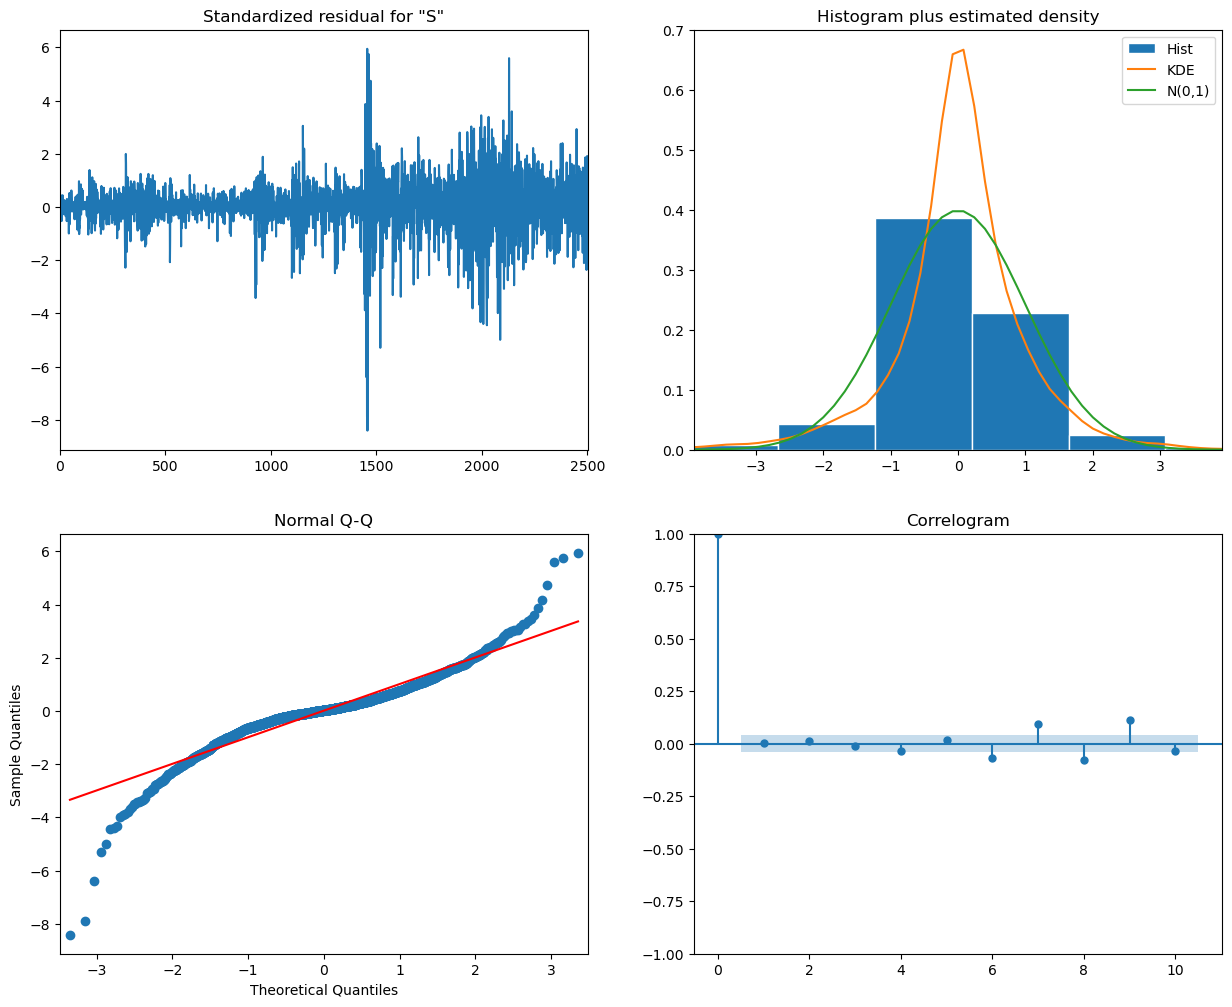

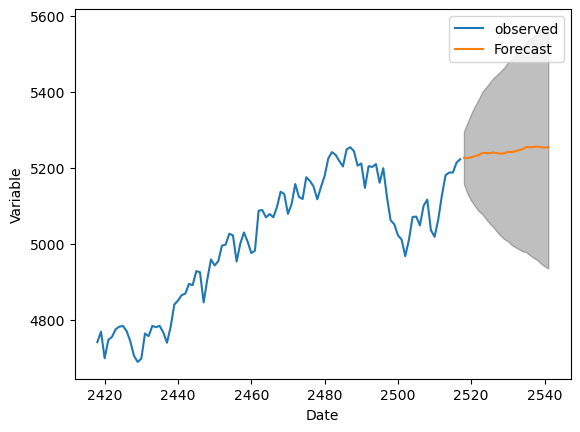

In [41]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting
pred = results.get_forecast(steps=24)  # Forecasting the next 24 time periods
pred_ci = pred.conf_int()
ax = ts[-100:].plot(label='observed')  # Last 100 observations
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Variable')
plt.legend()
plt.show()


# Exponential Smoothing (ETS):


### Configure and Fit ETS Models


In [42]:
#Exponential smooting (ETS)
# Simple Exponential Smoothing - for data with no clear trend or seasonality
model_simple = ExponentialSmoothing(ts, trend=None, seasonal=None, seasonal_periods=None)
fitted_model_simple = model_simple.fit()

# Double Exponential Smoothing - for data with a trend but no seasonality
model_double = ExponentialSmoothing(ts, trend='add', seasonal=None, seasonal_periods=None)
fitted_model_double = model_double.fit()

# Triple Exponential Smoothing - for data with both trend and seasonality
model_triple = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=12) 
fitted_model_triple = model_triple.fit()


Simple Model AIC: 17977.328076460362 BIC: 17988.99051688957
Double Model AIC: 17977.674619335558 BIC: 18000.999500193975
Triple Model AIC: 18016.369637120915 BIC: 18109.669160554586


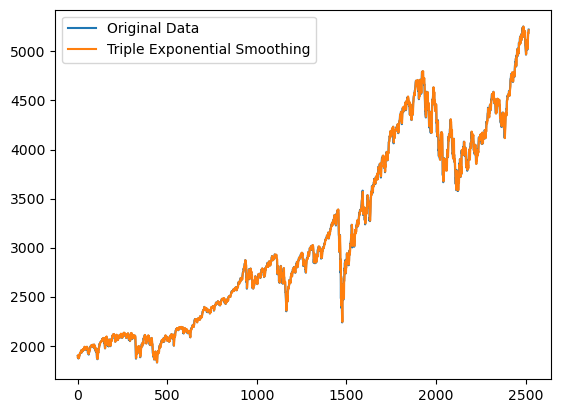

In [43]:
# Print AIC and BIC values to compare models
print('Simple Model AIC:', fitted_model_simple.aic, 'BIC:', fitted_model_simple.bic)
print('Double Model AIC:', fitted_model_double.aic, 'BIC:', fitted_model_double.bic)
print('Triple Model AIC:', fitted_model_triple.aic, 'BIC:', fitted_model_triple.bic)

# Plot the original data and the fitted values
ts.plot(label='Original Data', legend=True)
fitted_model_triple.fittedvalues.plot(label='Triple Exponential Smoothing', legend=True)
plt.show()


## Diagnostics and Validation


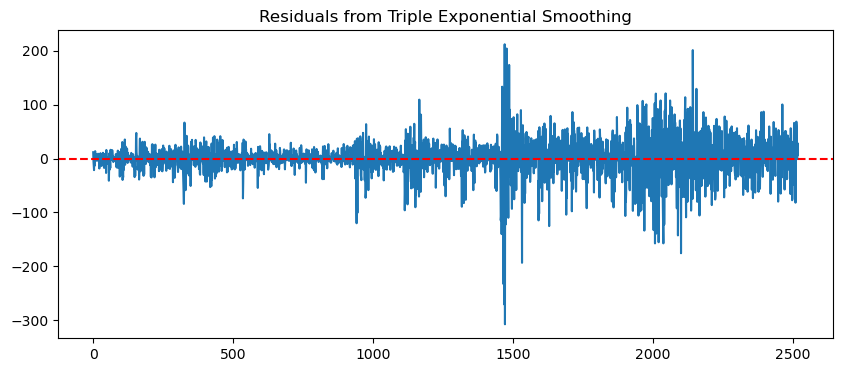

Statistics=544.317, p=0.000
Sample does not look Gaussian (reject H0)


In [44]:
# Assuming the triple model is the best
residuals = fitted_model_triple.resid

# Plotting residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from Triple Exponential Smoothing')
plt.axhline(y=0, color='r', linestyle='--')  # Zero line for reference
plt.show()

# Check for normality of residuals
from scipy.stats import normaltest
stat, p = normaltest(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


## Checking for autocorrelation

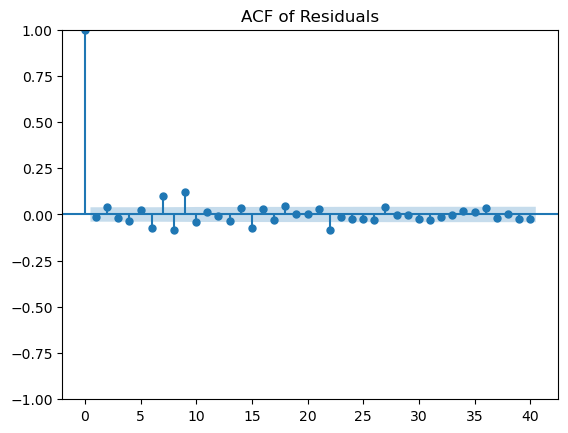

In [45]:

plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()


## Forecasting with Confidence Intervals


C:\Users\fatii\AppData\Local\Temp\ipykernel_6304\3180617622.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(ts.index[-1], periods=25, freq='M')[1:], forecast, label='Forecast')


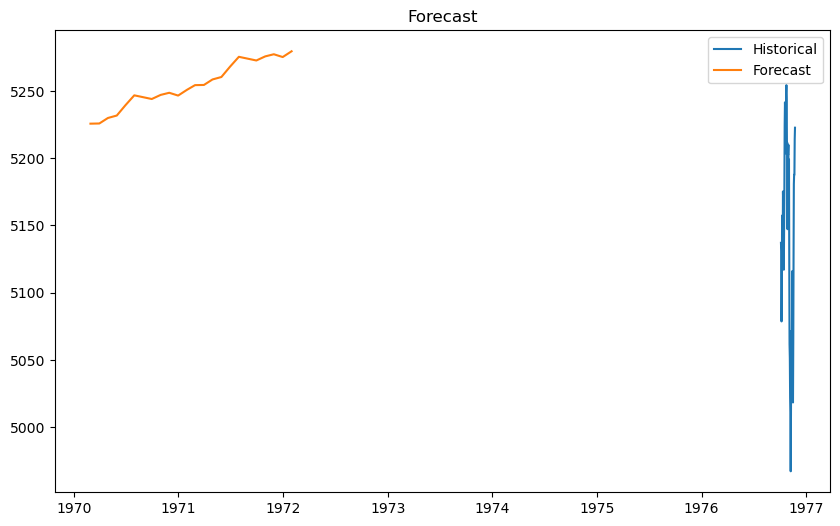

In [46]:
# Forecast the next 24 periods
forecast = fitted_model_triple.forecast(steps=24)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(ts.index[-50:], ts[-50:], label='Historical')
plt.plot(pd.date_range(ts.index[-1], periods=25, freq='M')[1:], forecast, label='Forecast')
plt.title('Forecast')
plt.legend()
plt.show()


# Prophet


## Combining day, month, year

In [51]:
#prophet
data['ds'] = data['Date']

data['y'] = data['S&P500']
prophet_data = data[['ds', 'y']]
print(prophet_data.head())



           ds        y
0  2014-05-12  1896.65
1  2014-05-13  1897.45
2  2014-05-14  1888.53
3  2014-05-15  1870.85
4  2014-05-16  1877.86


## Fitting a prophet model

00:17:27 - cmdstanpy - INFO - Chain [1] start processing
00:17:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


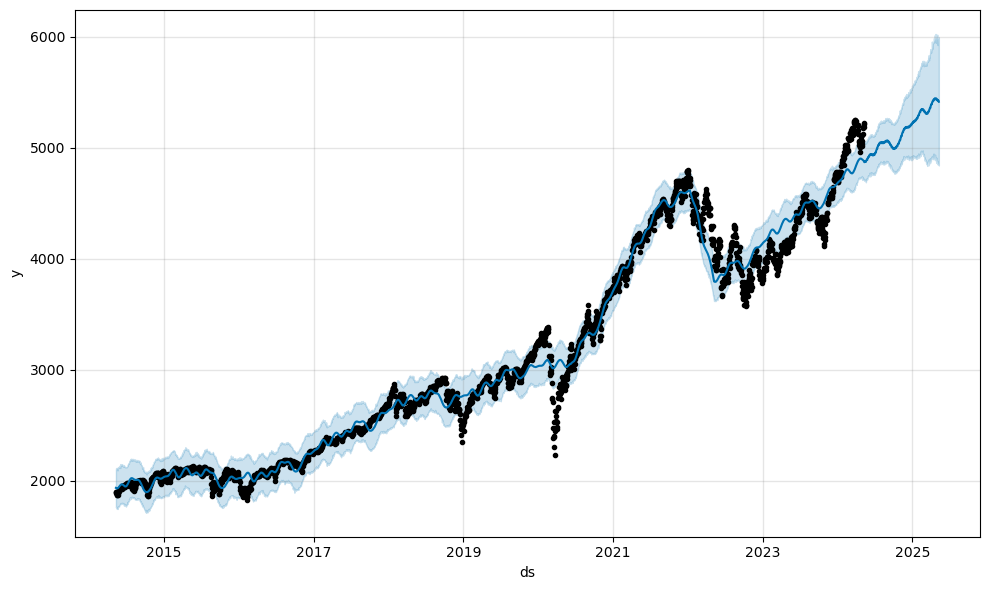

C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

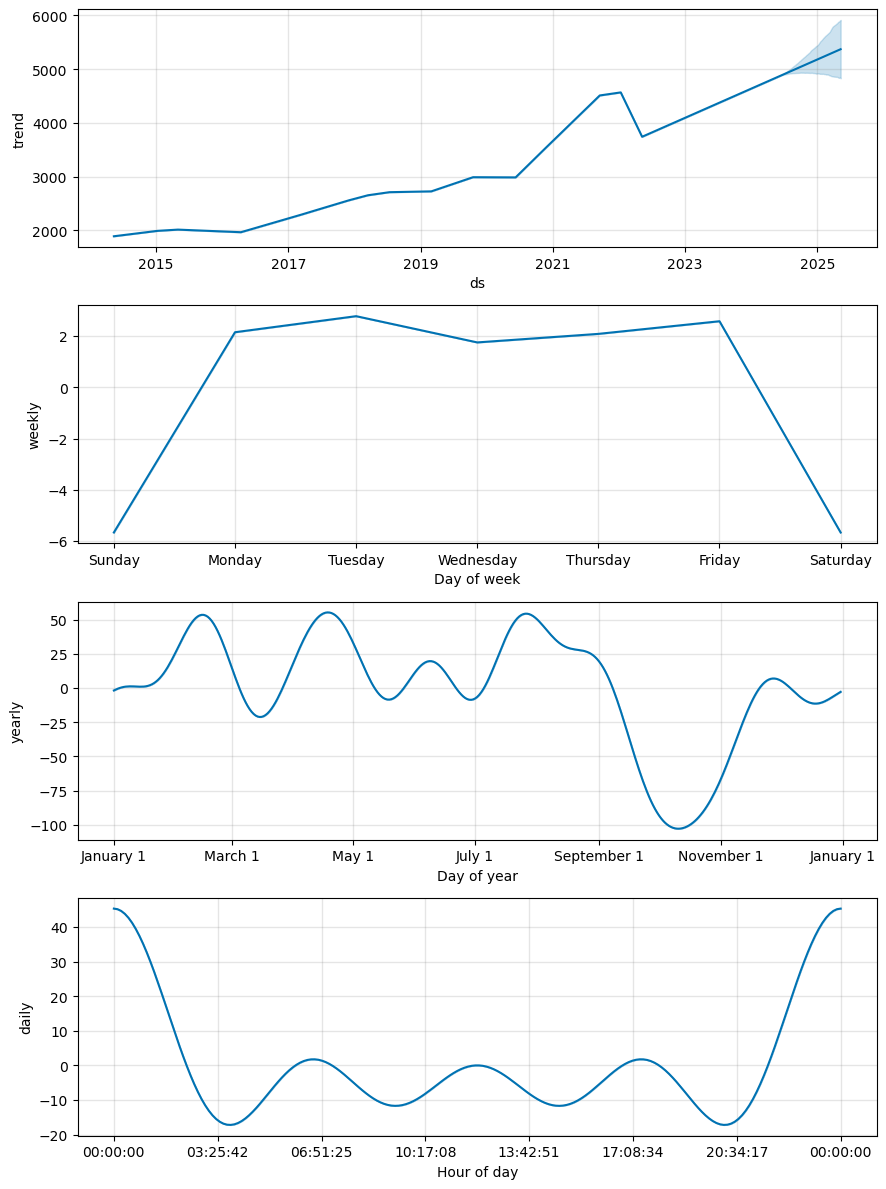

In [52]:
# Create a Prophet model instance
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

# Fit the model
m.fit(prophet_data)

# Create a DataFrame to hold predictions for the next 365 days
future = m.make_future_dataframe(periods=365)

# Make predictions
forecast = m.predict(future)

# Plot the forecast
fig = m.plot(forecast)
plt.show()

# Optionally, visualize the components of the forecast
components_fig = m.plot_components(forecast)
plt.show()


# Support Vector Regression (SVR):

In [85]:


# Assuming 'Date' column is in the format 'YYYY-MM-DD'
data['Date'] = pd.to_datetime(data['Date'])

# Extracting 'day', 'month', and 'year' columns from the datetime
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year

# Assuming other columns are numeric features
numeric_columns = ['day', 'month', 'year']  # List your numeric columns here
X = data[numeric_columns]
y = data['S&P500']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numeric data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Configuring and Training SVR

In [86]:
# Initialize and fit the SVR model
svr_rbf = SVR(kernel='rbf', C=1.0, gamma='auto')  
svr_rbf.fit(X_train_scaled, y_train)


SVR(gamma='auto')

## Evaluating the model

In [87]:
# Predicting and evaluating the performance
y_pred = svr_rbf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 644178.167859634


## Parameter Tunining with Cross Validation

In [88]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
}

# Create GridSearchCV object
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best parameters and MSE
print("Best parameters:", grid_search.best_params_)
best_mse = -grid_search.best_score_
print(f'Best MSE from CV: {best_mse}')


Best parameters: {'C': 100, 'gamma': 'scale'}
Best MSE from CV: 73583.48089867862


## Visualizing the Results

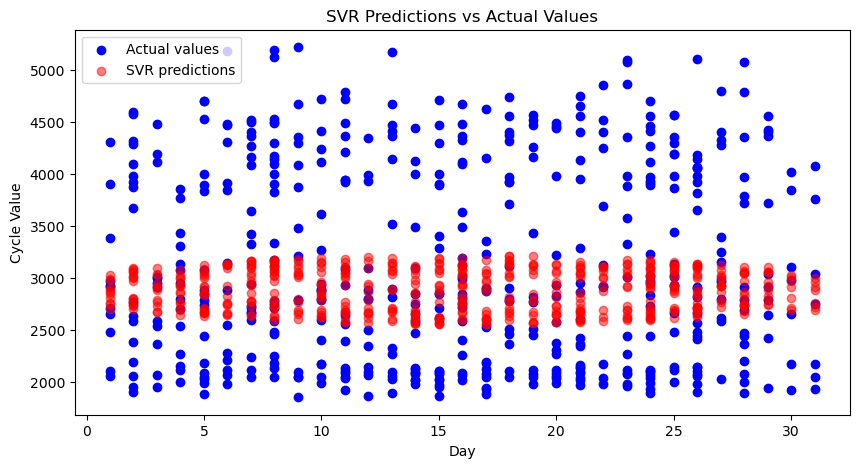

In [89]:
# Visualize predictions against actual data
plt.figure(figsize=(10, 5))
plt.scatter(X_test['day'], y_test, color='blue', label='Actual values')
plt.scatter(X_test['day'], y_pred, color='red', label='SVR predictions', alpha=0.5)
plt.xlabel('Day')
plt.ylabel('Cycle Value')
plt.title('SVR Predictions vs Actual Values')
plt.legend()
plt.show()


# Long Short-Term Memory (LSTM):

## Scaling the data

In [90]:
#LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['S&P500']].values.reshape(-1, 1))

# Function to create a dataset as required by LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  #number of previous timestamps
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

## Desigining LTSM Network

In [91]:
# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))  # 50 neurons in the LSTM layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


## Training the model

In [92]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=2)


Epoch 1/5
2012/2012 - 10s - loss: 0.0126 - 10s/epoch - 5ms/step
Epoch 2/5
2012/2012 - 8s - loss: 1.6336e-04 - 8s/epoch - 4ms/step
Epoch 3/5
2012/2012 - 8s - loss: 1.5418e-04 - 8s/epoch - 4ms/step
Epoch 4/5
2012/2012 - 7s - loss: 1.5449e-04 - 7s/epoch - 4ms/step
Epoch 5/5
2012/2012 - 9s - loss: 1.5593e-04 - 9s/epoch - 5ms/step


## Making predictions and Evaluating the model

In [93]:
# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(y_train_inv[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = np.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))


16/16 [==============================] - 0s 4ms/step
Train Score: 39.67 RMSE
Test Score: 38.23 RMSE


# Hybrid model implementation

###  Extract ARIMA Predictions and Calculate Residuals

In [97]:
predicted_values = model_fit.predict(start=data.index[0], end=data.index[-1])
residuals = data['S&P500'] - predicted_values


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## Train the ANN on Residuals

In [98]:
X = np.arange(len(residuals)).reshape(-1, 1)  
y = residuals.values

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ann_model = create_model(1, 20)  
ann_model.fit(X_train, y_train, epochs=10, batch_size=10)


Epoch 1/10
202/202 [==============================] - 2s 6ms/step - loss: 4619635.0000
Epoch 2/10
202/202 [==============================] - 1s 5ms/step - loss: 1139191.0000
Epoch 3/10
202/202 [==============================] - 1s 3ms/step - loss: 710224.2500
Epoch 4/10
202/202 [==============================] - 1s 3ms/step - loss: 705843.6875
Epoch 5/10
202/202 [==============================] - 1s 3ms/step - loss: 705314.6250
Epoch 6/10
202/202 [==============================] - 1s 3ms/step - loss: 704834.6250
Epoch 7/10
202/202 [==============================] - 1s 5ms/step - loss: 704517.4375
Epoch 8/10
202/202 [==============================] - 1s 6ms/step - loss: 703827.4375
Epoch 9/10
202/202 [==============================] - 1s 6ms/step - loss: 704081.0625
Epoch 10/10
202/202 [==============================] - 1s 6ms/step - loss: 703402.5625


# Predict Residuals and Adjust ARIMA Predictions

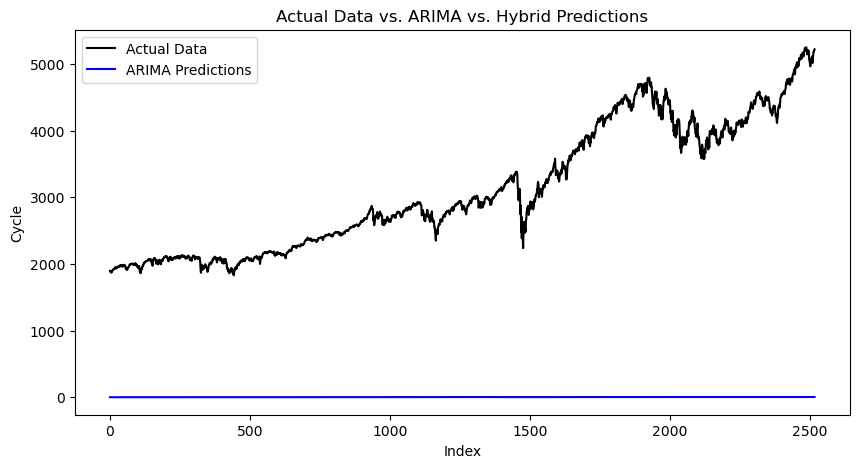

In [101]:
adjusted_arima_predictions = predicted_values[:len(data)]

plt.figure(figsize=(10, 5))
plt.plot(data.index, data['S&P500'], label='Actual Data', color='black')
plt.plot(data.index, adjusted_arima_predictions, label='ARIMA Predictions', color='blue')
plt.legend()
plt.title('Actual Data vs. ARIMA vs. Hybrid Predictions')
plt.xlabel('Index')
plt.ylabel('Cycle')
plt.show()



# Plotting future predictions

In [102]:
if len(predicted_values) > len(data):
    future_indices = range(len(data), len(predicted_values))
    plt.figure(figsize=(10, 5))
    plt.plot(future_indices, predicted_values[len(data):], label='Future ARIMA Predictions', color='green')
    plt.plot(future_indices, adjusted_predictions[len(data):], label='Future Hybrid Predictions', color='purple')
    plt.legend()
    plt.title('Future Predictions')
    plt.xlabel('Index')
    plt.ylabel('Cycle')
    plt.show()
